Check that we have the appropriate reader for Sentinel-2:

In [1]:
from satpy import Scene
from satpy.writers import get_enhanced_image
import matplotlib.pyplot as plt

from satpy import available_readers
print(sorted(available_readers()))

/var/folders/x5/84lgyr6j2t78v5b4r9ztb78w0000gn/T/ipykernel_90123/2264912158.py:2: UserWarning: 'satpy.writers.get_enhanced_image' has been moved to 'satpy.enhancements.enhancer.get_enhanced_image'. Import from the new location instead (ex. 'from satpy.enhancements.enhancer import get_enhanced_image'). The old import paths will be removed in Satpy 1.0
  from satpy.writers import get_enhanced_image


['abi_l1b', 'abi_l1b_scmi', 'abi_l2_nc', 'acspo', 'agri_fy4a_l1', 'agri_fy4b_l1', 'ahi_hrit', 'ahi_hsd', 'ahi_l1b_gridded_bin', 'ahi_l2_nc', 'amsr2_l1b', 'amsr2_l2', 'amsr2_l2_gaasp', 'amsub_l1c_aapp', 'atms_l1b_nc', 'atms_sdr_hdf5', 'avhrr_l1b_aapp', 'avhrr_l1b_eps', 'avhrr_l1b_hrpt', 'avhrr_l1c_eum_gac_fdr_nc', 'aws1_mwr_l1b_nc', 'aws1_mwr_l1c_nc', 'camel_l3_nc', 'cmsaf-claas2_l2_nc', 'electrol_hrit', 'epic_l1b_h5', 'eps_sterna_mwr_l1b_nc', 'fci_l1c_nc', 'fci_l2_nc', 'generic_image', 'geocat', 'gerb_l2_hr_h5', 'ghi_l1', 'ghrsst_l2', 'glm_l2', 'goci2_l2_nc', 'goes-imager_hrit', 'goes-imager_nc', 'gpm_imerg', 'hsaf_h5', 'hy2_scat_l2b_h5', 'iasi_l2', 'iasi_l2_cdr_nc', 'iasi_ng_l2_nc', 'ici_l1b_nc', 'insat3d_img_l1b_h5', 'jami_hrit', 'li_l2_nc', 'maia', 'meris_nc_sen3', 'mhs_l1c_aapp', 'mimicTPW2_comp', 'mirs', 'msi_l1c_earthcare', 'msi_safe', 'msi_safe_l2a', 'msu_gsa_l1b', 'mtsat2-imager_hrit', 'multiple_sensors_isccpng_l1g_nc', 'mviri_l1b_fiduceo_nc', 'mwi_l1b_nc', 'mws_l1b_nc', 'nucap

In [2]:
from satpy import Scene
import os

safe_path = "S2B_MSIL2A_20220717T105629_N0510_R094_T30TXQ_20240717T092238.SAFE"

# Collect all files under the .SAFE directory
input_files = []
for root, dirs, files in os.walk(safe_path):
    for fname in files:
        if fname.endswith(".jp2") or fname.endswith(".xml"):
            input_files.append(os.path.join(root, fname))

# Create scene
scn = Scene(filenames=input_files, reader="msi_safe_l2a")

# Print available composites and datasets
print("Available composites:\n", scn.available_composite_names())
print("Available datasets:\n", scn.available_dataset_names())

Available composites:
 []
Available datasets:
 ['AOT', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'SCL', 'WVP', 'satellite_azimuth_angle', 'satellite_zenith_angle', 'solar_azimuth_angle', 'solar_zenith_angle']


In [3]:
scn.load(['B04', 'B03', 'B02'])
scn['B04'].data.shape

(10980, 10980)

In [4]:
print(scn.available_composite_names())

[]


In [5]:
from satpy.composites.core import GenericCompositor

comp = GenericCompositor('my_rgb')
my_rgb = comp((scn['B04'], scn['B03'], scn['B02']))

In [6]:
my_rgb

<xarray.DataArray 'where-914e13e16e82ec017fcaf23dca3a8740' (bands: 3, y: 10980,
                                                            x: 10980)> Size: 1GB
dask.array<where, shape=(3, 10980, 10980), dtype=float32, chunksize=(1, 4096, 4096), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 88kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 88kB 5e+06 5e+06 5e+06 ... 4.89e+06 4.89e+06
    spatial_ref  int64 8B 0
    crs          object 8B PROJCRS["WGS 84 / UTM zone 30N",BASEGEOGCRS["WGS 8...
  * bands        (bands) <U1 12B 'R' 'G' 'B'
Attributes: (12/15)
    resolution:              10
    reader:                  msi_safe_l2a
    file_type:               l2a_safe_granule_10m
    standard_name:           boa_bidirectional_reflectance
    ancillary_variables:     []
    area:                    Area ID: 30TXQ\nDescription: On-the-fly area\nPr...
    ...                      ...
    start_time:              2022-07-17 11:08:52.413098
    wavelength:              None
    name:                    my_rgb
    prerequisites:           []
    optional_prerequisites:  []
    mode:                    RGB

In [7]:
from satpy.enhancements.enhancer import get_enhanced_image

In [8]:
img = get_enhanced_image(my_rgb)

In [9]:
# get DataArray out of `XRImage` object
img_data = img.data

CPU times: user 47.9 s, sys: 5.84 s, total: 53.7 s
Wall time: 18 s


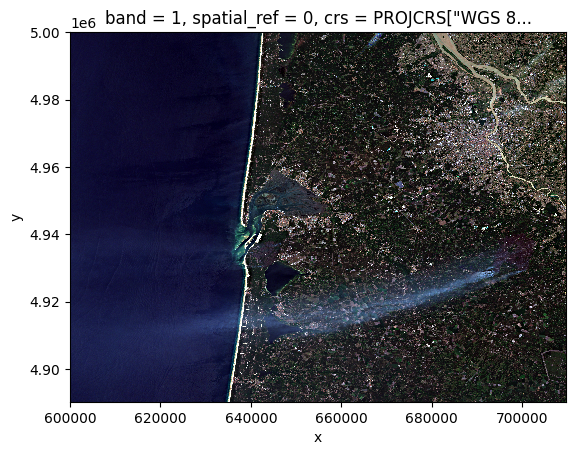

In [10]:
%%time
img_data.plot.imshow(vmin=0, vmax=1, rgb='bands')

## Crop

We are going to convert from EPSG:32630 to EPSG:4326 (lat/lon), then crop in this coordinate system.

In [11]:
from pyresample import geometry


# Landiras
spatial_extent = {
    "west": -0.86,
    "south": 44.411911,
    "east": -0.38,
    "north": 44.617554,
    "crs": "EPSG:4326"
}

# 10m = 0.00008983 deg at equator
resolution_deg = 0.00008983
width = int((spatial_extent["east"] - spatial_extent["west"]) / resolution_deg)
height = int((spatial_extent["north"] - spatial_extent["south"]) / resolution_deg)

# Define the area for resampling (EPSG:4326)
area_def = geometry.AreaDefinition(
    area_id="cropped_latlon",
    description="Cropped area in lat/lon",
    proj_id="latlon",
    projection="EPSG:4326",
    width=width,
    height=height,
    area_extent=(
        spatial_extent["west"],
        spatial_extent["south"],
        spatial_extent["east"],
        spatial_extent["north"],
    ),
)

In [12]:
%%time
# Resample the scene to the geographic grid
resampled_scn = scn.resample(area_def)

INFO:satpy.resample.base:Using default KDTree resampler


CPU times: user 14.3 s, sys: 44.3 ms, total: 14.4 s
Wall time: 14.5 s


In [13]:
cropped_rgb = comp((resampled_scn['B04'], resampled_scn['B03'], resampled_scn['B02']))

In [14]:
cropped_rgb

<xarray.DataArray 'where-b8b937de10662b9ba09daa63cb26248b' (bands: 3, y: 2289,
                                                            x: 5343)> Size: 147MB
dask.array<where, shape=(3, 2289, 5343), dtype=float32, chunksize=(1, 2289, 4096), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
    crs          object 8B GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1...
  * y            (y) float64 18kB 44.62 44.62 44.62 44.62 ... 44.41 44.41 44.41
  * x            (x) float64 43kB -0.86 -0.8599 -0.8598 ... -0.3801 -0.38
  * bands        (bands) <U1 12B 'R' 'G' 'B'
Attributes: (12/15)
    resolution:              10
    reader:                  msi_safe_l2a
    file_type:               l2a_safe_granule_10m
    standard_name:           boa_bidirectional_reflectance
    ancillary_variables:     []
    area:                    Area ID: cropped_latlon\nDescription: Cropped ar...
    ...                      ...
    start_time:              2022-07-17 11:08:52.413098
    wavelength:              None
    name:                    my_rgb
    prerequisites:           []
    optional_prerequisites:  []
    mode:                    RGB

CPU times: user 9.87 s, sys: 1.06 s, total: 10.9 s
Wall time: 3.42 s


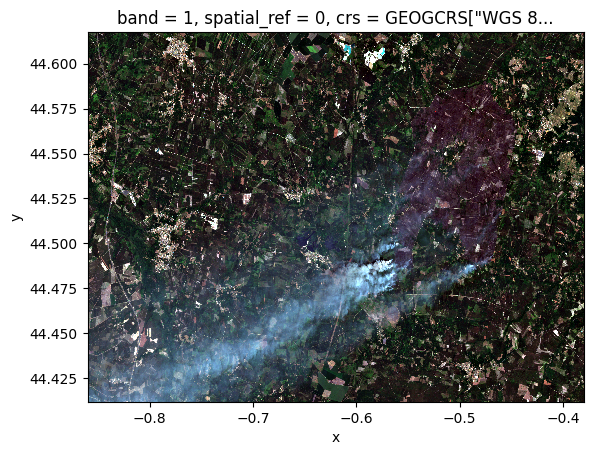

In [15]:
%%time
cropped_img = get_enhanced_image(cropped_rgb)
cropped_img_data = cropped_img.data

cropped_img_data.plot.imshow(vmin=0, vmax=1, rgb='bands')

## Add our custom RGB to the scene

In [29]:
cropped_img_data.attrs.update({
    "name": "my_rgb",
    "platform_name": resampled_scn['B04'].attrs.get("platform_name"),
    "sensor": resampled_scn['B04'].attrs.get("sensor"),
    "start_time": resampled_scn['B04'].attrs.get("start_time"),
    "end_time": resampled_scn['B04'].attrs.get("end_time"),
    "file_type": "custom",
    "area": resampled_scn['B04'].attrs.get("area"),
    "crs": area_def.crs.to_wkt(),
})

resampled_scn['my_rgb'] = cropped_img_data

In [30]:
print(list(resampled_scn.keys()))

[DataID(name='B02', wavelength=WavelengthRange(min=0.44, central=0.49, max=0.54, unit='µm'), resolution=10, calibration=<1>, modifiers=('esa_sunz_corrected', 'esa_rayleigh_corrected')), DataID(name='B03', wavelength=WavelengthRange(min=0.54, central=0.56, max=0.58, unit='µm'), resolution=10, calibration=<1>, modifiers=('esa_sunz_corrected', 'esa_rayleigh_corrected')), DataID(name='B04', wavelength=WavelengthRange(min=0.645, central=0.665, max=0.685, unit='µm'), resolution=10, calibration=<1>, modifiers=('esa_sunz_corrected', 'esa_rayleigh_corrected')), DataID(name='my_rgb', resolution=10)]


In [32]:
resampled_scn.save_datasets(filename='cropped_rgb.nc', engine='netcdf4')

INFO:satpy.writers.cf_writer:Saving datasets to NetCDF4/CF.


[None]

In [33]:
import xarray
ds = xarray.open_dataset('cropped_rgb.nc')
print(ds)

<xarray.Dataset> Size: 489MB
Dimensions:             (y: 2289, x: 5343, bands: 3)
Coordinates: (12/13)
    B02_band            int64 8B ...
    B02_spatial_ref     int64 8B ...
  * y                   (y) float64 18kB 44.62 44.62 44.62 ... 44.41 44.41 44.41
  * x                   (x) float64 43kB -0.86 -0.8599 -0.8598 ... -0.3801 -0.38
    longitude           (y, x) float64 98MB ...
    latitude            (y, x) float64 98MB ...
    ...                  ...
    B03_spatial_ref     int64 8B ...
    B04_band            int64 8B ...
    B04_spatial_ref     int64 8B ...
    my_rgb_band         int64 8B ...
    my_rgb_spatial_ref  int64 8B ...
  * bands               (bands) <U1 12B 'R' 'G' 'B'
Data variables:
    cropped_latlon      int64 8B ...
    B02                 (y, x) float32 49MB ...
    B03                 (y, x) float32 49MB ...
    B04                 (y, x) float32 49MB ...
    my_rgb              (bands, y, x) float32 147MB ...
Attributes:
    history:      Created by pytro

In [34]:
ds["my_rgb"]

<xarray.DataArray 'my_rgb' (bands: 3, y: 2289, x: 5343)> Size: 147MB
[36690381 values with dtype=float32]
Coordinates: (12/13)
    B02_band            int64 8B ...
    B02_spatial_ref     int64 8B ...
  * y                   (y) float64 18kB 44.62 44.62 44.62 ... 44.41 44.41 44.41
  * x                   (x) float64 43kB -0.86 -0.8599 -0.8598 ... -0.3801 -0.38
    longitude           (y, x) float64 98MB ...
    latitude            (y, x) float64 98MB ...
    ...                  ...
    B03_spatial_ref     int64 8B ...
    B04_band            int64 8B ...
    B04_spatial_ref     int64 8B ...
    my_rgb_band         int64 8B ...
    my_rgb_spatial_ref  int64 8B ...
  * bands               (bands) <U1 12B 'R' 'G' 'B'
Attributes: (12/14)
    crs:                     GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System...
    end_time:                2022-07-17 11:08:52.413098
    enhancement_history:     {"scale": "<xarray.DataArray (bands: 3)> Size: 1...
    file_type:               custom
    grid_mapping:            cropped_latlon
    mode:                    RGB
    ...                      ...
    prerequisites:           []
    reader:                  msi_safe_l2a
    resolution:              10
    sensor:                  msi
    standard_name:           boa_bidirectional_reflectance
    start_time:              2022-07-17 11:08:52.413098

In [23]:
area_def.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich